# Investigating Fandango Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest (Fandango is an online movie ratings aggregator). He published his analysis in this [article](https://fivethirtyeight.com/features/fandango-movies-ratings/) — a great piece of data journalism that's
worth reading.

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.
Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

1. The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
2. In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be "rounded off" to 5 stars.
3. For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

Here is the data dictionary for FiveThirtyEight's data set:

![fandango_scores](img/fandango_score_ddict.png)

And here is the corresponding data dictionary for the follow up record of film ratings from 2016-2017:

![ratings_16_17](img/movie_ratings_16_17_ddict.png)

## Data exploration

In [1]:
# Basic import statements
import pandas as pd

In [2]:
original_scores = pd.read_csv('fandango_score_comparison.csv')
updated_scores = pd.read_csv('movie_ratings_16_17.csv')

original_scores.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [3]:
updated_scores.head(3)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


In [4]:
orig_fandango_cols = ['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']
fandango_original = original_scores[orig_fandango_cols].copy()

updated_fandango_cols = ['movie', 'year', 'fandango']
fandango_updated = updated_scores[updated_fandango_cols].copy()

print(fandango_original.info())
print(fandango_updated.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 5 columns):
FILM                    146 non-null object
Fandango_Stars          146 non-null float64
Fandango_Ratingvalue    146 non-null float64
Fandango_votes          146 non-null int64
Fandango_Difference     146 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 5.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 3 columns):
movie       214 non-null object
year        214 non-null int64
fandango    214 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.1+ KB
None


The population of interest for our analysis is the set of all flims scored on Fandango over the years. Our objective is to assess whether the population parameters (namely apparent score) have changed in the time since the FiveThirtyEight article. 

The sample of films included in the FiveThirtyEight data set were obtained using the following conditions measured on the sampling date of Aug. 24, 2015:
1. Film has a Rotten Tomatoes rating and User rating
2. Film has a Metacritic score and Metacritic User score
3. Film has an IMDb score
4. Film has at least 30 fan ratings on Fandango's website at the time of sampling

The sampling is not random, since it explicitly excludes films that did not have enough Fandango fan ratings at the time the sample was taken. While this indicates that the sample might not be *truly* representative of the total population of Fandango-rated films, I would argue that this shifts the population of interest from all films listed towards films with a degree of certainty about their rating (as measured by the number of fan ratings).

On the other hand, the `README` file for the updated Fandango data set specifies that films were sampled on Mar. 22, 2017 according to:
1. A release date between 2016 and 2017
2. A "significant number" of votes/reviews

This sampling is also not randomized and is furthermore vague about it's selection criteria since it is unclear what qualifies as a "significant number" of votes or reviews. Nevertheless, it still matches the intent of the FiveThirtyEight sample to maintain some certainty about the rating of the films included.

With these factors in mind, we conclude that these data sets don't exactly represent our original population of every film scored on Fandango. To fix this, we will slightly adjust our objective and target population so that the data we have is more meaningful. We will specifically look at popular films released in 2015 and 2016, and try to assess if there is any significant difference between the two groups of ratings. Although not as meaningful as the first objective, this adjusted goal is a reasonable proxy for the original.

Ideally, we would decide on a set definition for a popular movie (like FiveThirtyEight's definition that a movie is popular if it has at least 30 fan ratings). However, as we mentioned above, the second dataset doesn't include information about the number of reviews. In this case it would be best to validate this dataset to make sure that all (or at least most) of the films qualify as popular. Ideally this would be done with a query to an exposed Fandango API to check the count of fan reviews and add them to the second dataset, which we could then filter for popular films only. Unfortunately Fandango no longer exposes the count of fan reviews (possibly as a means to thwart discovery of this kind of issue again!) so to save time, we'll take it on face value that the two datasets are comprable in terms of popularity. Note that "in the real world" (in other words, in a business setting), skipping this step would be much more difficult to swallow and we would likely have to check the data some other way.

At the very least we can do a sanity check on the first dataset:

In [5]:
pop_thresh = 30
cond = fandango_original['Fandango_votes'] < 30
print("Count of 'unpopular' films in first dataset: {}".format(len(fandango_original[cond])))

Count of 'unpopular' films in first dataset: 0


In [6]:
# Extract year from 'FILM' column
fandango_original['Year'] = fandango_original['FILM'].str.extract(pat="\((\w+)\)")
print("fandango_original film year distribution:")
print(fandango_original['Year'].value_counts())

fandango_original film year distribution:
2015    129
2014     17
Name: Year, dtype: int64


In [7]:
# Select 2015 films
cond = fandango_original['Year']=='2015'
fandango_2015 = fandango_original[cond].copy()
fandango_2015.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


In [8]:
print("fandango_update film year distribution:")
print(fandango_updated['year'].value_counts())

fandango_update film year distribution:
2016    191
2017     23
Name: year, dtype: int64


In [9]:
# Select 2016 films
cond = fandango_updated['year']==2016
fandango_2016 = fandango_updated[cond].copy()
fandango_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191 entries, 0 to 213
Data columns (total 3 columns):
movie       191 non-null object
year        191 non-null int64
fandango    191 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.0+ KB


## KDE distribution approximation

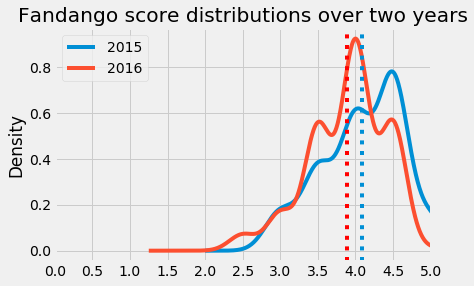

In [28]:
# Initial KDE plots for Fandango score distributions between 2015 and 2016

import matplotlib.pyplot as plt
import numpy as np

mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

plt.style.use('fivethirtyeight')
ax = fandango_2015['Fandango_Stars'].plot.kde(label='2015')
ax = fandango_2016['fandango'].plot.kde(label='2016')
ax.axvline(x=mean_2015, linestyle=':')
ax.axvline(x=mean_2016, linestyle=':', color='r')
ax.legend()
ax.set_title('Fandango score distributions over two years')

ticks = np.linspace(0.0, 5.0, 11)
ax.set_xlim(0., 5)
ax.set_xticks(ticks) 
_ = ax.set_xticklabels(ticks)

Given a random year of releases, we would expect the scores to be roughly normally distributed around some mean score (which might change based on the year). If the scale were "saturated" --that is if film scores were distributed across the scale from 0.0 to 5.0, a fair guess would be that scores should be distributed around the mid-point of the scale at 2.5. From the KDE plot above, we can see that the score distributions for both years do not saturate the scale, in fact they both skew hard left with a mean of just above 4.0 for 2015 and about 3.9 for 2016. This tells us that film scores for both years are biased towards high ratings of greater than 4.0. 

Moreover, we can clearly identify that the two distributions do not share a similar shape. In particular, the 2015 scores are not normally distributed around the mean score. On the other hand, while the 2016 score distribution is still far from a perfect Gaussian, it is nevertheless much more symmetric about it's mean. 

The significant difference between the shapes of these two distributions lends itself to the conclusion that there was a systematic change between the reviews of popular movies between 2015 and 2016. The left shift of the 2016 distribution indicates that ratings in 2016 were on average slightly lower than in 2015.

## Comparing relative frequencies

In [11]:
frmt_string = " Year: {year} \n " + "-"*20
print(frmt_string.format(year=2015))
fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index()

 Year: 2015 
 --------------------


3.0    0.085271
3.5    0.178295
4.0    0.286822
4.5    0.379845
5.0    0.069767
Name: Fandango_Stars, dtype: float64

In [12]:
print(frmt_string.format(year=2016))
fandango_2016['fandango'].value_counts(normalize = True).sort_index()

 Year: 2016 
 --------------------


2.5    0.031414
3.0    0.073298
3.5    0.240838
4.0    0.403141
4.5    0.246073
5.0    0.005236
Name: fandango, dtype: float64

Comparing the two frequency tables, we can see that there were significantly more very high scores (4.5 or 5.0) submitted in 2015 compared to 2016. In 2015, more than %40 of flims were awarded either a 4.5 or a 5.0 score, while films with high scores in 2016 accounted for just %25 of the total films that year. The magnitude of this change alone indicates that the two distributions are different.

Looking at the low end of film scores, %8.5 of films in 2015 were assigned a low score of 3.0 or less. In 2016, this segment grew to just over %10. While this might not be a noteworthy change in and of itself, it is worth pointing out that the lowest score in 2015 was a 3.0, which shrunk to a 2.5 in 2016. 

One area where there is a greater proportion of scores in 2016 are the more moderate scores of 3.5 and 4.0. In 2015, these scores accounted for %47 of films which grew to %64 in 2016. 

In [27]:
dfs = [fandango_2015['Fandango_Stars'], fandango_2016['fandango']]
summary_stats = {'mean': [df.mean() for df in dfs], 'median': [df.median() for df in dfs], 'mode':[df.mode()[0] for df in dfs]}

summary_stats = pd.DataFrame(summary_stats, index=['2015', '2016'])
summary_stats.head()

,mean,median,mode
2015,4.085271,4.0,4.5
2016,3.887435,4.0,4.0


Comparing the summary statistics, the mean score awarded in 2016 was 0.2 stars lower than in 2015. However, the median score did not change between the two data sets, indicating that for both years half of the scores in our data were above/below 4.0. The mode in 2016 was lower by a half-score, going from a 4.5 in 2015 to 4.0. These statistics combined with the KDE plots earlier tell us that the scoring in 2016 was in fact slightly lower than it was in 2015.

Text(0, 0.5, 'Score')

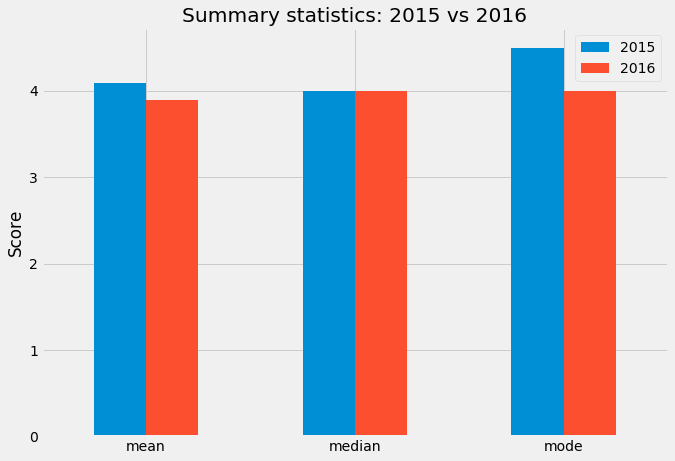

In [44]:
plt.style.use('fivethirtyeight')
ax = summary_stats.transpose().plot.bar(rot=0, figsize=(10,7))
ax.set_title('Summary statistics: 2015 vs 2016')
ax.set_ylabel('Score')